<a href="https://colab.research.google.com/github/tmedeirosb/modelo_ifrn_integrado/blob/master/PAPER_EXPERT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: XXXX
# Journal: Expert System with Application 

## Abstract: XXXX

O objetivo deste notebook é mostrar que o uso de técnicas de imbalanced learning pode melhorar a acurácia de modelos preditivos de evasão. 

Na primeira parte do paper serão feitos dois modelos: xxx. 

Na segunda parte será utilizada a técnica Balanced Bagging (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html) com o core DT. 

Para cada modelo serão gerados as métricas: precision, accuracy, recall, ROC, confusion matrix e G-mean. Este último será utilizado para comparação entre modelos como indicado para problemas de dados desbalanceados (https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf). 

Ao fim é feito o teste de p-value para confirmar se houve diferença estatística entre o desempenho dos modelos

Import packages 

In [0]:
#import packages

#graphs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()

#google drive
import os
from google.colab import drive

#data crawling
import numpy as np
import pandas as pd

#evalueting models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef

#selecionando atributos 
from sklearn.feature_selection import RFECV

#classic models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#imbalanced
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_validate
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalanceCascade
import operator
from sklearn.base import clone
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

from imblearn.pipeline import make_pipeline as make_imb_pipeline

import collections
from collections import Counter 
from collections import OrderedDict

#show graphs in notebook
%matplotlib inline

Import database. The construct the database is available in https://github.com/tmedeirosb/modelo_ifrn_integrado/blob/master/versao_2/workflow_criando_base.ipynb 

In [2]:
#impor database
drive.mount('/content/drive')
dados_tunning = pd.read_json('/content/drive/My Drive/Colab Notebooks/dados/dados_workflow_ivan.json')
dados = dados_tunning.copy()
dados.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(8908, 33)

Functions to pre-process data (remove NaN, dummies transform),  and evaluate the model



In [0]:
#config enviroment
#show all columns
pd.set_option('display.max_columns', None)

#clean the NaN
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    #print(dados_clean.info())
    
    return (dados_clean, y)

#plot roc curve
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#evaluating models
def evaluating(model, ytest, ypred, Xtest):
    #matriz de confusao (AP: atual positivo, AN: atual negativo, PP: pred. positivo, PN: pred. negativo)
    #     AN | AP 
    # --------------
    # PN: TN | FN
    # PP: FP | TP

    #Text summary of the precision, recall, F1 score for each class
    #precision = TP/(TP+FP); TN/(TN+FN) 
    #recall    = TP/(TP+FN); TN/(TN+FP)
    print(classification_report(ytest, ypred))  
    
    print("Matthews correlation coefficient")
    print(matthews_corrcoef(ytest, ypred))
    
    print("G-mean")
    print(geometric_mean_score(ytest, ypred))    
    
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    #tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()    
    #print(tp)
    #print(tn)
    #print(fn)
    #print(fp)
    #print( tn/(tn+fp) )
    
    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print("AUC: %f" % roc_auc_score(ytest, y_scores))
    
def plot_alg_comp(results, names):
  fig = plt.figure()
  fig.suptitle('Algorithm Comparison')
  fig.set_size_inches(11.7, 8.27)
  ax = fig.add_subplot(111)
  plt.boxplot( results )
  ax.set_xticklabels( names )
  plt.xticks(rotation=90)
  plt.show()

#metric recall min
def recall_min(y_true, y_pred):
  tn = confusion_matrix(y_true, y_pred)[0, 0]
  fp = confusion_matrix(y_true, y_pred)[0, 1]
  return tn/(tn+fp)


Define os atributos da base de dados e, caso ainda tenha valores NAN, substituti por -1

In [4]:
#select attributes
atributos = [
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]

dados = dados[atributos]

#fill NAN
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

#use original data
dados = dados[dados.artificial == 0]

print(dados.classe.value_counts())

dados.head(2)

1    7369
0     349
Name: classe, dtype: int64


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,15,F,False,0,1,2,LAJ,1
10,61.0,0,100.0,60.0,0,100.0,0,False,0,1,B,A,Urbana,Pais,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino médio completo,Ensino médio completo,Parda,Ensino médio completo,Mãe,Não informado,15,M,True,0,2,5,CANG,2


Separa os dados em 25% de teste e 75% de treino. Os dois folds são estratificados de acordo com o balanceamento da classe de evasão, a fim de manter a proporção dos dados do conjunto original. 

Esse conjunto de dados será utilizado em todos os modelos

In [5]:
#split data test and training. Stratify like imbalanced classes
X, y = preparing_data(dados)
print(X.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify = y)

(7718, 31)
(7718, 31)
(7718, 151)


In [0]:
class ModelML:
  def __init__(self, model, hyperparameters=None, balance=""):
        self.base = model
        self.name = model.__class__.__name__+" "+balance        
        self.hyperparameters = hyperparameters
        self.best_attr = balance
        self.balance = None
        self.best_params = None
        self.best_score = None
        self.best_model = None
        

#seleciona os melhores atributos para cada modelo
def select_attr(models, Xtrain, ytrain, columns):
  #seleciona os melhores atributos por modelo
  for model in models:

      if model.name in ['SVC', 'MLPClassifier']:
          continue

      print(model.name)
      print('-'*len(model.name))

      #seleciona os melhores atributos para cada modelo
      #selector = RFECV(model.base, cv=10, n_jobs=-1)
      #selector = RFECV(model.base, cv=10, n_jobs=-1, scoring="roc_auc") 
      selector = RFECV(clone(model.base), cv=10, n_jobs=-1, scoring=make_scorer(geometric_mean_score))
      selector.fit(Xtrain, ytrain)

      best_columns = list(columns[selector.support_])
      print("Best Columns \n{}\n".format(best_columns))    

      #salva os melhores atributos para o modelo
      model.best_attr = best_columns   

#ranking dos atributos pela frequencia que ocorreu para cada modelo
def show_ranking_attr(models):

  ranking_attr = []
  tmp = []

  for model in models:
    #print(model.best_attr)
    tmp.append(model.best_attr)

  print(tmp)
  x = sum(tmp, [])

  counter = collections.Counter(x)

  sorted_dict = OrderedDict(sorted(counter.items(), key=lambda t: t[1], reverse=True))
  cnt = 0
  for k, v in sorted_dict.items():
      print(cnt, k, v)
      cnt = cnt + 1
      
  return sorted_dict

#cria lista de modelos que serao utilizados no trabalho
def make_list_model(balance=""):
  #DEFINICAO DOS MODELOS A SEREM TREINADOS
  par_DT = {
            "criterion": ["gini", "entropy"],
            "max_depth": [None, 3, 5],
            "max_leaf_nodes": [None, 5, 10, 20]
            }

  par_SVC = {
              "kernel": ['rbf'],  
              "C": [0.001, 0.01, 0.1, 1, 10],
            }

  par_LR = {
              "solver": ["newton-cg", "lbfgs", "liblinear"]
            }

  par_MLP = {
                  'solver': ['lbfgs'], 
                  'max_iter': [200],
                  'alpha': 10.0 ** -np.arange(1, 4), 
                  'hidden_layer_sizes':np.arange(5, 20, 3), 
                  'random_state':[0]
              }

  par_RF = {
                "max_features": ["auto"],
                'n_estimators': [10, 30, 100, 200, 300]
            }



  models = [ModelML(DecisionTreeClassifier(), par_DT, balance), 
            #ModelML(SVC(probability=True, gamma='auto'), par_SVC), 
            ModelML(LogisticRegression(solver="lbfgs"), par_LR, balance), 
            #ModelML(MLPClassifier(), par_MLP), 
            #ModelML(RandomForestClassifier(n_estimators=10), par_RF)
           ]
  
  return models

#seleciona o melhor conjunto de atributos (freq > 1)
def select_best_attr_comite(sorted_under, models):
  #selecionando os melhores atributos do comite

  #deve ter sido selecionado ao menos por duas tecnicas
  attr_2 = [k for k, v in sorted_under.items() if v > 1]
  print(attr_2)

  #max_freq = (max(sorted_under.values()))
  #attr_max = [k for k, v in sorted_under.items() if v == max_freq]
  #print(attr_max)

  #atualiza os melhores atributos
  for model in models:
    model.best_attr = attr_2
    

#treina cada modelo de acordo com os melhores atributos
def select_model_tun(Xtrain, Xtest, ytrain, ytest, models):
    results = []
    names = []   
    
    #treina o modelo de acordo com os atributos selecionados
    for model in models:    
        if len(model.best_attr) == 0:
            model.best_attr = Xtrain.columns            

        Xtrain_2 = Xtrain[model.best_attr]
        Xtest_2  = Xtest[model.best_attr]


        print(model.name)
        #print(model.best_attr)
        print('-'*len(model.name))         
        
        grid = GridSearchCV(model.base,
                            param_grid=model.hyperparameters,
                            cv=10, 
                            scoring=make_scorer(geometric_mean_score))
        
        grid.fit(Xtrain_2, ytrain)
        model.best_params = grid.best_params_
        model.best_score = grid.best_score_
        model.best_model = grid.best_estimator_

        print("Best Score: {}".format(model.best_score))
        print("Best Parameters: {}".format(model.best_params))
        
def evaluating_models(models, Xtest, ytest, results, names):

  kfold = model_selection.KFold(n_splits=10, random_state=42)

  #avaliacao individual por modelo
  for model in models:        
      print('\n\n'+model.name)
      print('-'*len(model.name))

      #sim
      ypred = model.best_model.predict(Xtest[model.best_attr])
      evaluating(model.best_model, ytest, ypred, Xtest[model.best_attr])

      #boxplot
      #testa 10 vezes o modelo, a fim de gerar estatística para ser avaliado no p-value
      cv_results = model_selection.cross_val_score(model.best_model, 
                                                   Xtest[model.best_attr], 
                                                   ytest, 
                                                   cv=kfold, 
                                                   scoring=make_scorer(geometric_mean_score))
      model.cv_results = cv_results
      results.append(cv_results)
      names.append(model.name)
      msg = "Mean G-MEAN do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
      print(msg)

  # boxplot algorithm comparison
  plot_alg_comp(results, names)
  
  return(results, names)

DecisionTreeClassifier 
-----------------------
Best Score: 0.6679746461593038
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None}
LogisticRegression 
-------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Score: 0.5368841192922973
Best Parameters: {'solver': 'newton-cg'}


DecisionTreeClassifier 
-----------------------
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        87
           1       0.98      0.97      0.97      1843

   micro avg       0.95      0.95      0.95      1930
   macro avg       0.72      0.77      0.74      1930
weighted avg       0.96      0.95      0.95      1930

Matthews correlation coefficient
0.4795111225872309
G-mean
0.7383685176998162


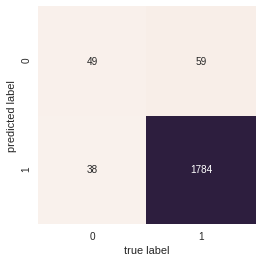

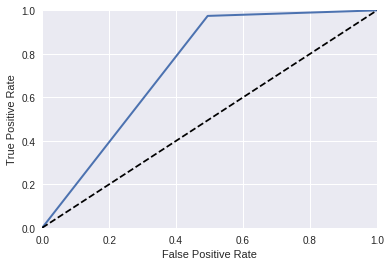

AUC: 0.740123
Mean G-MEAN do conjunto de testes: 0.721081 (0.150828) 



LogisticRegression 
-------------------
              precision    recall  f1-score   support

           0       0.72      0.38      0.50        87
           1       0.97      0.99      0.98      1843

   micro avg       0.97      0.97      0.97      1930
   macro avg       0.84      0.69      0.74      1930
weighted avg       0.96      0.97      0.96      1930

Matthews correlation coefficient
0.5063436500970249
G-mean
0.6137057903333687


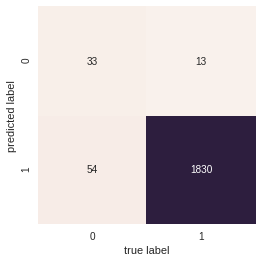

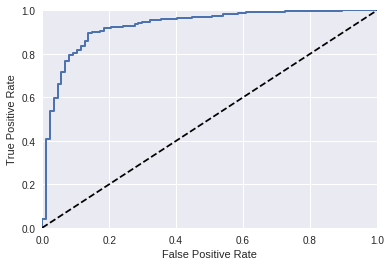

AUC: 0.928215
Mean G-MEAN do conjunto de testes: 0.637652 (0.097641) 



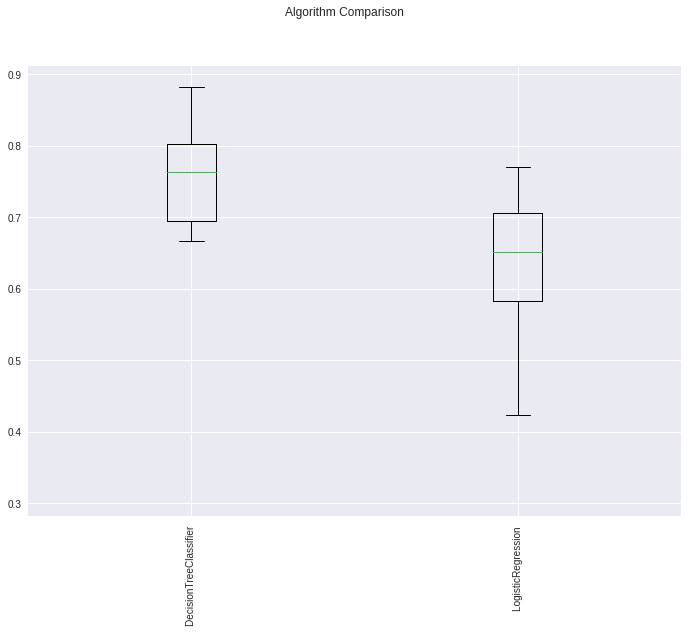

([array([0.69958415, 0.3110005 , 0.88245306, 0.78668998, 0.8010688 ,
         0.66674991, 0.82741488, 0.69329862, 0.80329091, 0.73925475]),
  array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
         0.73651717, 0.62017367, 0.64012545, 0.69950326, 0.66120955])],
 ['DecisionTreeClassifier ', 'LogisticRegression '])

In [7]:
#modelo sem balanceamento e com todos os atributos 
models_sem = make_list_model()

#seleciona o melhor modelo
select_model_tun(Xtrain, Xtest, ytrain, ytest, models_sem)

#avaliacao dos modelos 
results = []
names = []    
evaluating_models(models_sem, Xtest, ytest, results, names)

DecisionTreeClassifier UNDER
----------------------------
Best Columns 
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'artificial', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_I', 'conceito_freq_R', 'conceito_freq_S', 'descricao_area_residencial_Comunidade Quilombola', 'descricao_area_residencial_Não informado', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Não informado', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'desc

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Columns 
['conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'descricao_historico_Técnico de Nível Médio em Edificações', 'descricao_historico_Técnico de Nível Médio em Mecatrônica', 'descricao_pai_escolaridade_Não conhece', 'descricao_responsavel_financeiro_Irmão(ã)']

[['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'artificial', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_I', 'conceito_freq_R', 'conceito_freq_S', 'descricao_area_residencial_Comunidade Quilombola', 'descricao_area_residencial_Não informado', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_co

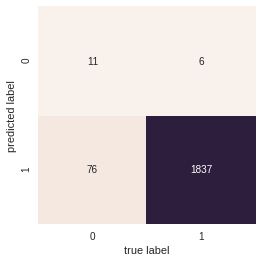

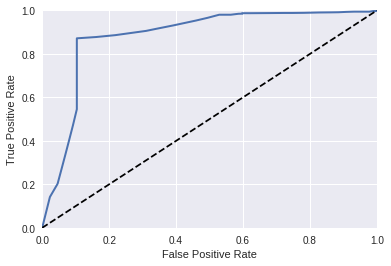

AUC: 0.881652
Mean G-MEAN do conjunto de testes: 0.621110 (0.099253) 



LogisticRegression UNDER
------------------------
              precision    recall  f1-score   support

           0       0.62      0.09      0.16        87
           1       0.96      1.00      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.79      0.54      0.57      1930
weighted avg       0.94      0.96      0.94      1930

Matthews correlation coefficient
0.226362382949253
G-mean
0.3028275989203496


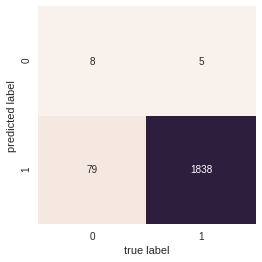

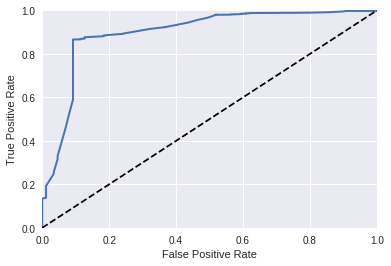

AUC: 0.896820
Mean G-MEAN do conjunto de testes: 0.358386 (0.253293) 



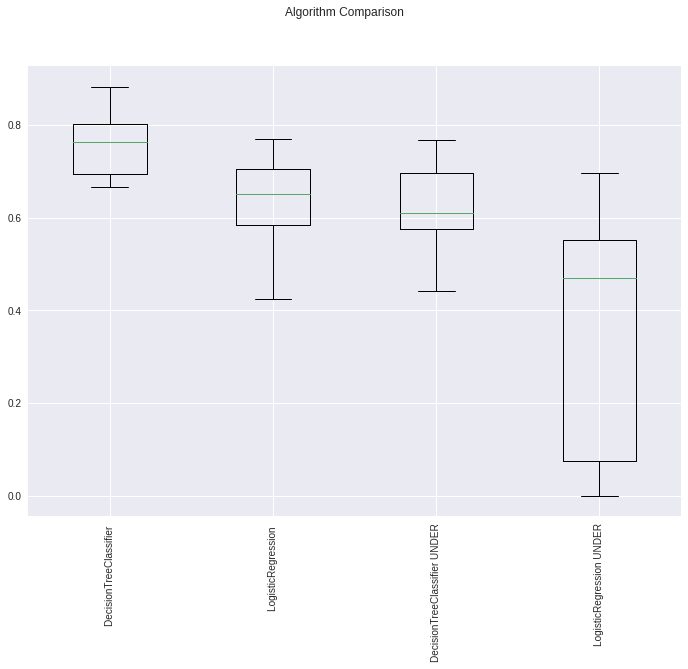

([array([0.69958415, 0.3110005 , 0.88245306, 0.78668998, 0.8010688 ,
         0.66674991, 0.82741488, 0.69329862, 0.80329091, 0.73925475]),
  array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
         0.73651717, 0.62017367, 0.64012545, 0.69950326, 0.66120955]),
  array([0.49734746, 0.44229901, 0.76839152, 0.73651717, 0.69758943,
         0.60136375, 0.61844857, 0.57735027, 0.69758943, 0.57420392]),
  array([0.49867549, 0.44229901, 0.        , 0.30151134, 0.69758943,
         0.        , 0.        , 0.5       , 0.56957939, 0.57420392])],
 ['DecisionTreeClassifier ',
  'LogisticRegression ',
  'DecisionTreeClassifier UNDER',
  'LogisticRegression UNDER'])

In [8]:
#SELECIONA OS MELHORES ATRIBUTOS PARA O UNDER SAMPLE
models_under = make_list_model("FEAT_UNDER")

#balanceamento de dados
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(Xtrain, ytrain)

#seleciona os melhores atributos
select_attr(models_under, X_under, y_under, Xtrain.columns)

#ranking dos melhores atributos
sorted_under = show_ranking_attr(models_under)

#selecionando os melhores atributos
select_best_attr_comite(sorted_under, models_under)

#seleciona melhor modelo com os atributos selecionados
select_model_tun(Xtrain, Xtest, ytrain, ytest, models_under)

#avalia modelos
evaluating_models(models_under, Xtest, ytest, results, names)

DecisionTreeClassifier SMOTE
----------------------------
Best Columns 
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'artificial', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_I', 'conceito_freq_R', 'conceito_freq_S', 'descricao_area_residencial_Não informado', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Não informado', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_companhia_domiciliar_Sozinho(a)', 'descricao_e

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

Best Columns 
['MatemticaI120H_dependencia', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'possui_necessidade_especial', 'qnt_pc', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_S', 'conceito_freq_I', 'conceito_freq_R', 'descricao_area_residencial_Não informado', 'descricao_area_residencial_Rural', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Não informado', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_companhia_domiciliar_Sozinho(a)', 'descricao_estado_civil_Divorciado(a)', 'descricao_estado_civil_Não declarado', 'descricao_estado_civil_União Estável', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nivel Médio em Biocombustíveis', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Administração'

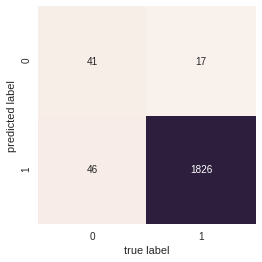

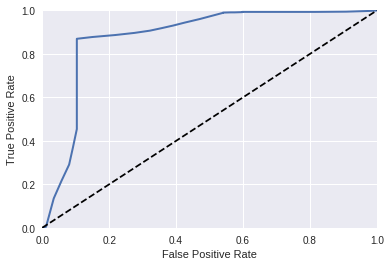

AUC: 0.877056
Mean G-MEAN do conjunto de testes: 0.670629 (0.085865) 



LogisticRegression SMOTE
------------------------
              precision    recall  f1-score   support

           0       0.64      0.24      0.35        87
           1       0.97      0.99      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.80      0.62      0.66      1930
weighted avg       0.95      0.96      0.95      1930

Matthews correlation coefficient
0.3758857435243505
G-mean
0.4897016029428383


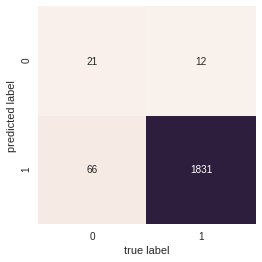

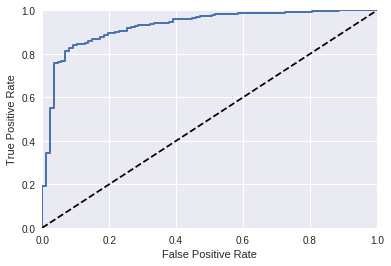

AUC: 0.928771
Mean G-MEAN do conjunto de testes: 0.474231 (0.089961) 



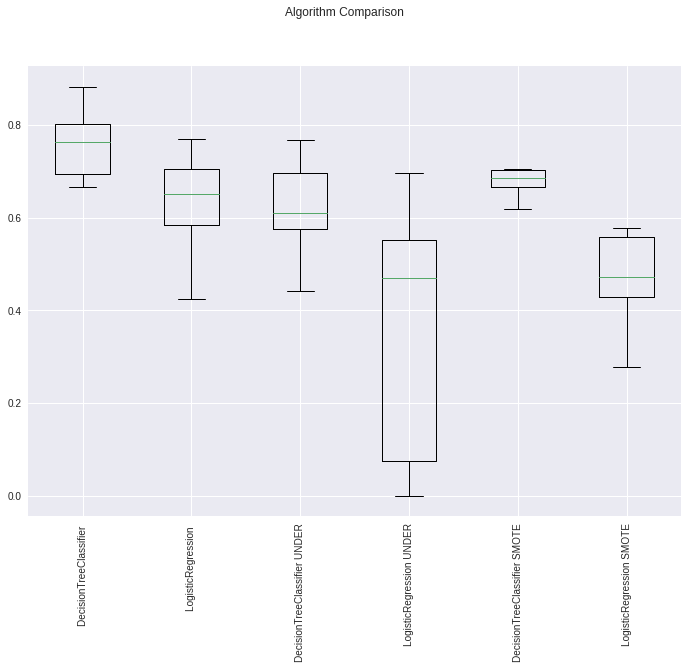

([array([0.69958415, 0.3110005 , 0.88245306, 0.78668998, 0.8010688 ,
         0.66674991, 0.82741488, 0.69329862, 0.80329091, 0.73925475]),
  array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
         0.73651717, 0.62017367, 0.64012545, 0.69950326, 0.66120955]),
  array([0.49734746, 0.44229901, 0.76839152, 0.73651717, 0.69758943,
         0.60136375, 0.61844857, 0.57735027, 0.69758943, 0.57420392]),
  array([0.49867549, 0.44229901, 0.        , 0.30151134, 0.69758943,
         0.        , 0.        , 0.5       , 0.56957939, 0.57420392]),
  array([0.70523365, 0.44599003, 0.76839152, 0.67234511, 0.69758943,
         0.67419986, 0.61844857, 0.76164985, 0.69758943, 0.6648526 ]),
  array([0.49867549, 0.44599003, 0.44363105, 0.42522839, 0.57114202,
         0.52223297, 0.2773501 , 0.57575317, 0.40496033, 0.57735027])],
 ['DecisionTreeClassifier ',
  'LogisticRegression ',
  'DecisionTreeClassifier UNDER',
  'LogisticRegression UNDER',
  'DecisionTreeClassifier SMOTE',
  'Logi

In [9]:
#SELECIONA OS MELHORES ATRIBUTOS PARA O SMOTE SAMPLE
models_smote = make_list_model("FEAT_SMOTE")

#balanceamento de dados
rsm = SMOTE(random_state=42)
X_smote, y_smote = rsm.fit_resample(Xtrain, ytrain)

#seleciona os melhores atributos
select_attr(models_smote, X_smote, y_smote, Xtrain.columns)

#ranking dos melhores atributos
sorted_smote = show_ranking_attr(models_smote)

#selecionando os melhores atributos
select_best_attr_comite(sorted_smote, models_smote)

#treina o modelo com os melhores atributos
select_model_tun(Xtrain, Xtest, ytrain, ytest, models_smote)

#avalia os modelos
evaluating_models(models_smote, Xtest, ytest, results, names)

In [0]:
#function test all balance config
def test_all_balance(models, balanced_tecn, name_balanced_tecn, Xtrain, ytrain, Xtest, ytest, results, names):
  for model in models:
    print(model.name)
    print(name_balanced_tecn)
    print('-'*len(model.name))
 
    sample = make_imb_pipeline(balanced_tecn, clone(model.best_model))

    #treino
    sample.fit(Xtrain[model.best_attr], ytrain)

    #predicao
    ypred = sample.predict(Xtest[model.best_attr])

    #avaliação 
    evaluating(sample, ytest, ypred, Xtest[model.best_attr])

    cv_results = model_selection.cross_val_score(sample, Xtest[model.best_attr], ypred, 
                                                 cv=model_selection.KFold(
                                                     n_splits=10, random_state=42),
                                                     scoring=make_scorer(geometric_mean_score))

    results.append(cv_results)
    names.append(model.name+' - '+name_balanced_tecn)

    msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
    print(msg)

    # boxplot algorithm comparison
    plot_alg_comp(results, names)

DecisionTreeClassifier 
ALL_FEAT_BAL_US
-----------------------
              precision    recall  f1-score   support

           0       0.17      0.82      0.28        87
           1       0.99      0.81      0.89      1843

   micro avg       0.81      0.81      0.81      1930
   macro avg       0.58      0.81      0.59      1930
weighted avg       0.95      0.81      0.86      1930

Matthews correlation coefficient
0.31621892155807424
G-mean
0.8139030523543889


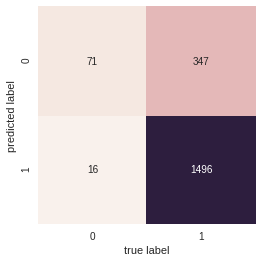

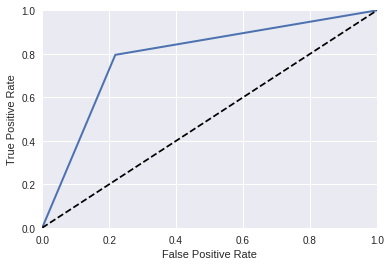

AUC: 0.788526
Score do conjunto de testes: 0.945084 (0.022839) 



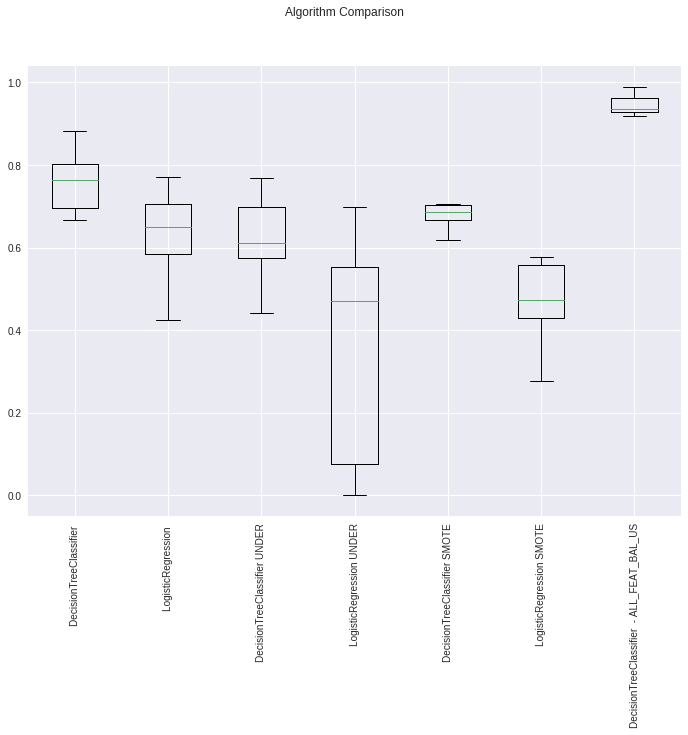

LogisticRegression 
ALL_FEAT_BAL_US
-------------------
              precision    recall  f1-score   support

           0       0.24      0.87      0.38        87
           1       0.99      0.87      0.93      1843

   micro avg       0.87      0.87      0.87      1930
   macro avg       0.62      0.87      0.65      1930
weighted avg       0.96      0.87      0.90      1930

Matthews correlation coefficient
0.4151257557076319
G-mean
0.8711243795002996


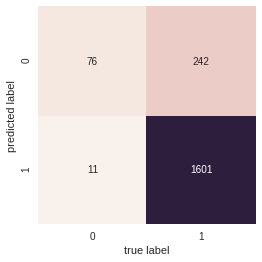

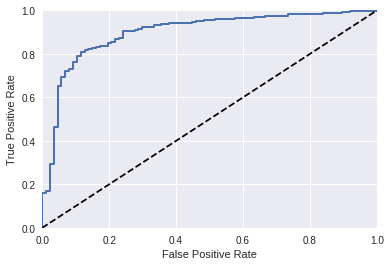

AUC: 0.898965
Score do conjunto de testes: 0.963186 (0.021321) 



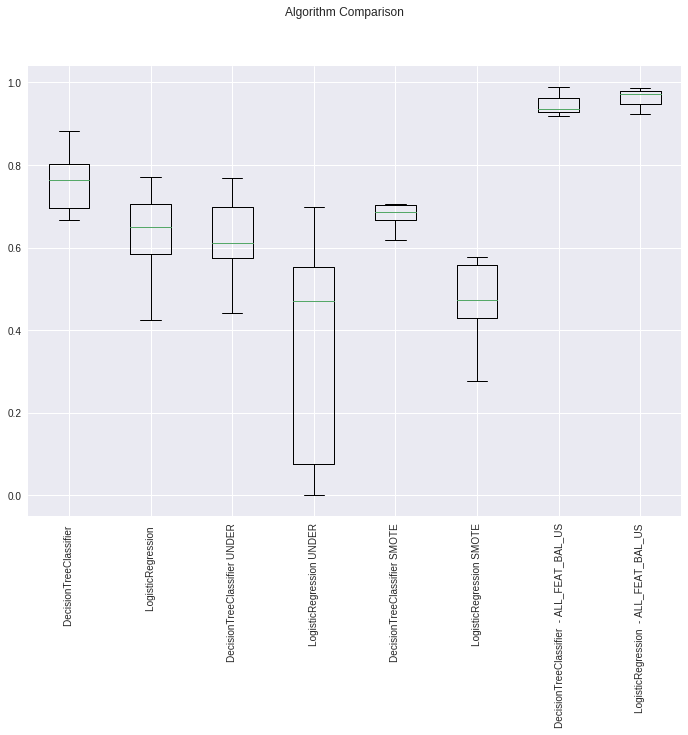

DecisionTreeClassifier 
ALL_FEAT_BAL_SM
-----------------------
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        87
           1       0.98      0.98      0.98      1843

   micro avg       0.96      0.96      0.96      1930
   macro avg       0.74      0.75      0.75      1930
weighted avg       0.96      0.96      0.96      1930

Matthews correlation coefficient
0.4967803315009633
G-mean
0.7184097265206266


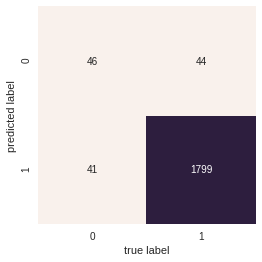

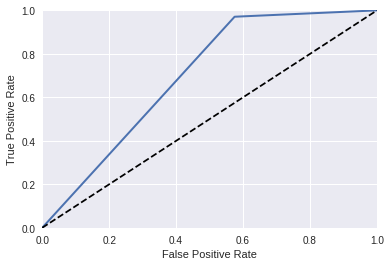

AUC: 0.697994
Score do conjunto de testes: 0.655836 (0.126899) 



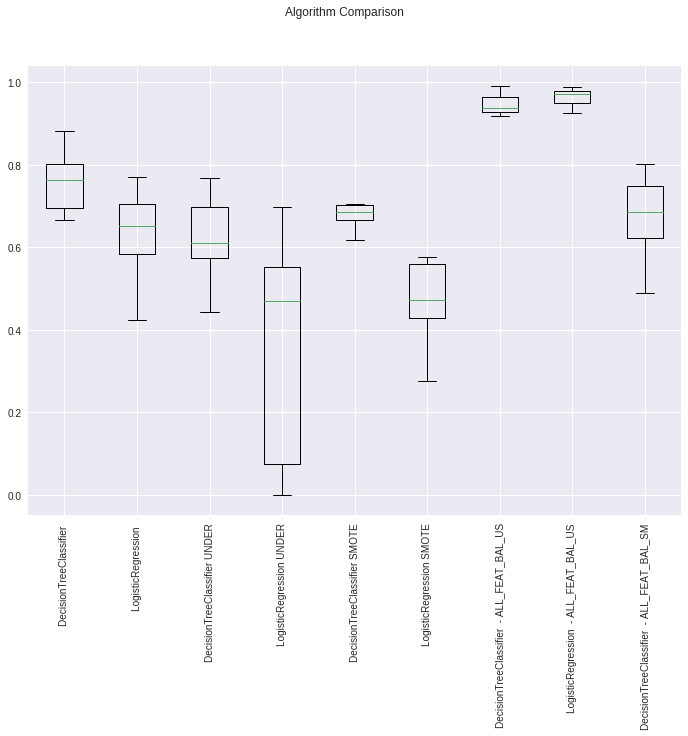

LogisticRegression 
ALL_FEAT_BAL_SM
-------------------
              precision    recall  f1-score   support

           0       0.25      0.79      0.38        87
           1       0.99      0.89      0.93      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.84      0.66      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.4006987460671353
G-mean
0.8382920428606195


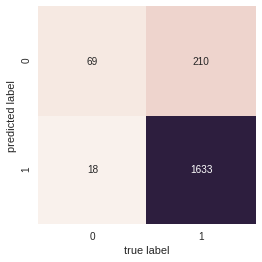

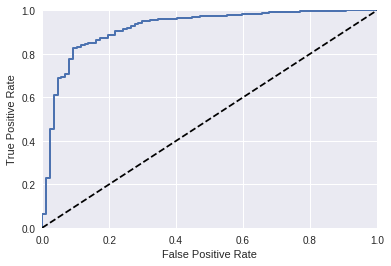

AUC: 0.920008
Score do conjunto de testes: 0.945310 (0.023598) 



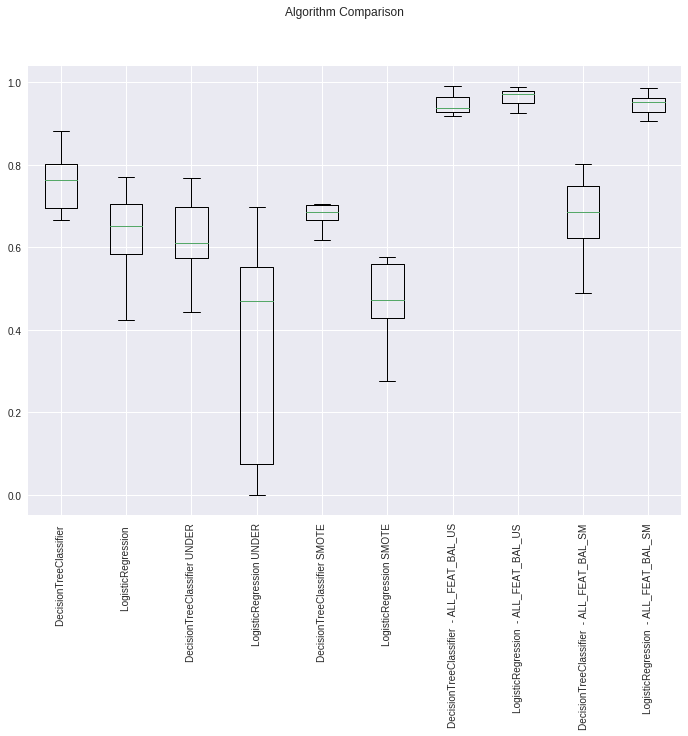

DecisionTreeClassifier UNDER
US_FEAT_BAL_US
----------------------------
              precision    recall  f1-score   support

           0       0.23      0.91      0.37        87
           1       0.99      0.86      0.92      1843

   micro avg       0.86      0.86      0.86      1930
   macro avg       0.61      0.88      0.65      1930
weighted avg       0.96      0.86      0.90      1930

Matthews correlation coefficient
0.4181832769202522
G-mean
0.8831443791147718


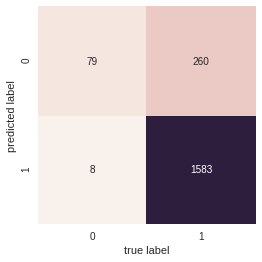

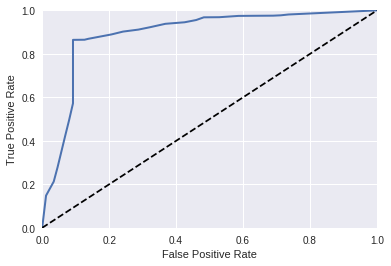

AUC: 0.891778
Score do conjunto de testes: 1.000000 (0.000000) 



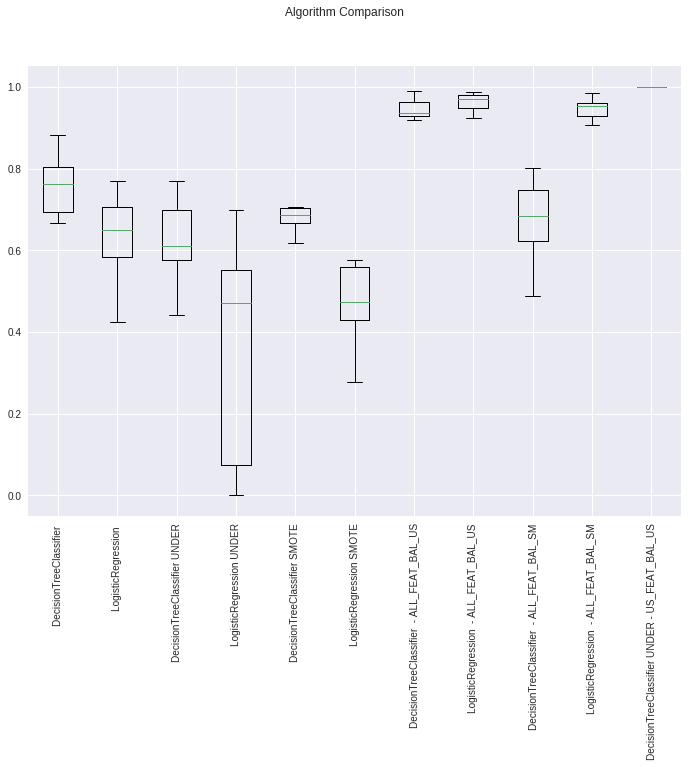

LogisticRegression UNDER
US_FEAT_BAL_US
------------------------
              precision    recall  f1-score   support

           0       0.24      0.91      0.38        87
           1       1.00      0.86      0.93      1843

   micro avg       0.87      0.87      0.87      1930
   macro avg       0.62      0.89      0.65      1930
weighted avg       0.96      0.87      0.90      1930

Matthews correlation coefficient
0.4261569564204914
G-mean
0.8859294518722629


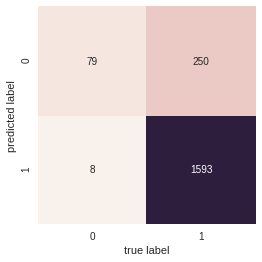

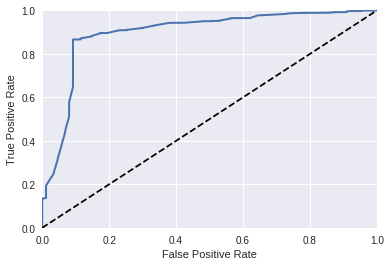

AUC: 0.895972
Score do conjunto de testes: 1.000000 (0.000000) 



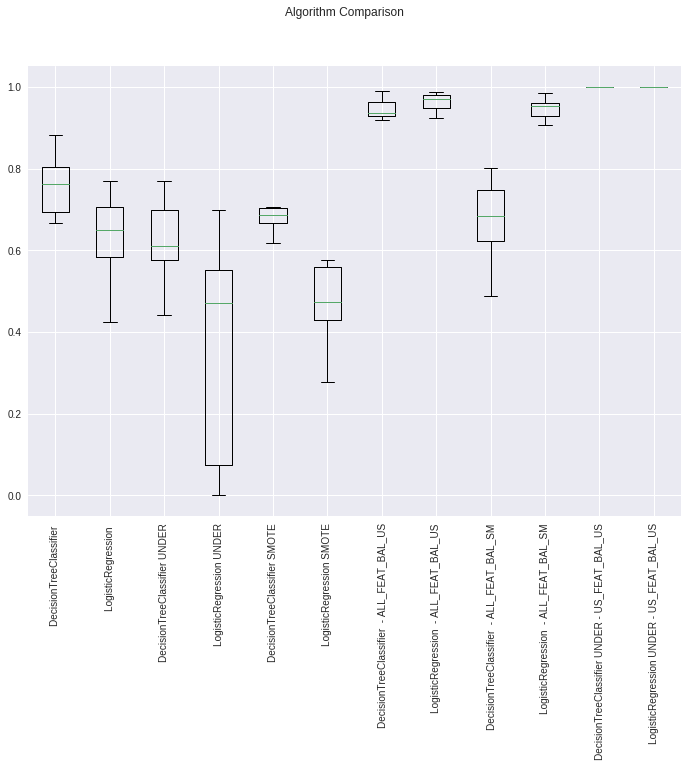

DecisionTreeClassifier SMOTE
SM_FEAT_BAL_SM
----------------------------
              precision    recall  f1-score   support

           0       0.24      0.90      0.38        87
           1       0.99      0.87      0.93      1843

   micro avg       0.87      0.87      0.87      1930
   macro avg       0.62      0.88      0.66      1930
weighted avg       0.96      0.87      0.90      1930

Matthews correlation coefficient
0.4269080475117757
G-mean
0.8825121096206808


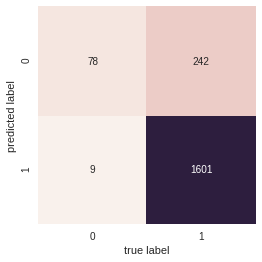

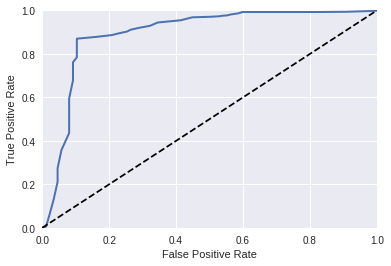

AUC: 0.893168
Score do conjunto de testes: 1.000000 (0.000000) 



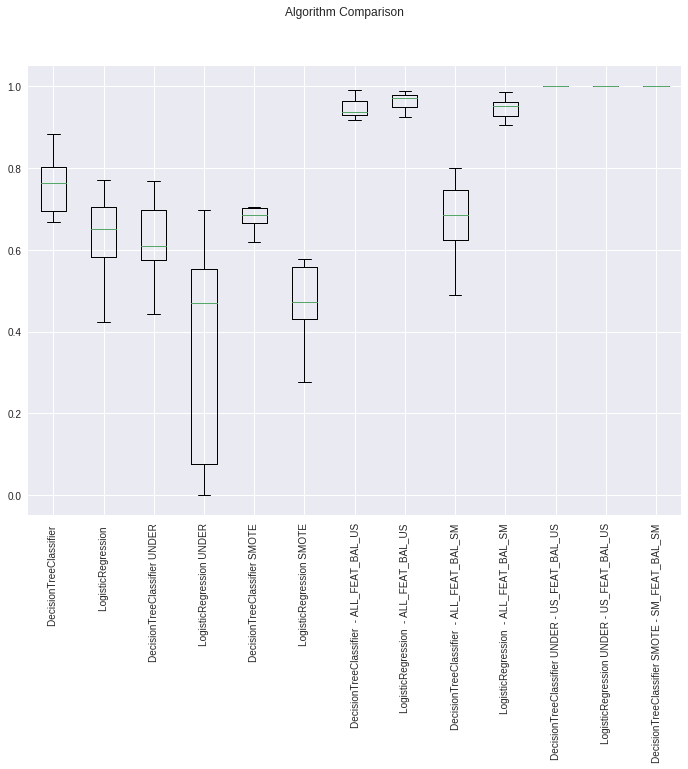

LogisticRegression SMOTE
SM_FEAT_BAL_SM
------------------------
              precision    recall  f1-score   support

           0       0.26      0.82      0.39        87
           1       0.99      0.89      0.94      1843

   micro avg       0.88      0.88      0.88      1930
   macro avg       0.62      0.85      0.66      1930
weighted avg       0.96      0.88      0.91      1930

Matthews correlation coefficient
0.4158423906507266
G-mean
0.8511351574874796


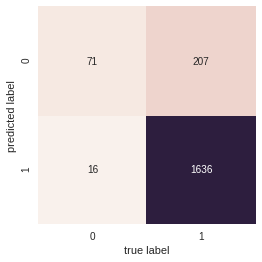

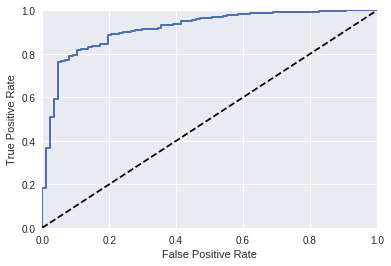

AUC: 0.917083
Score do conjunto de testes: 0.966976 (0.022709) 



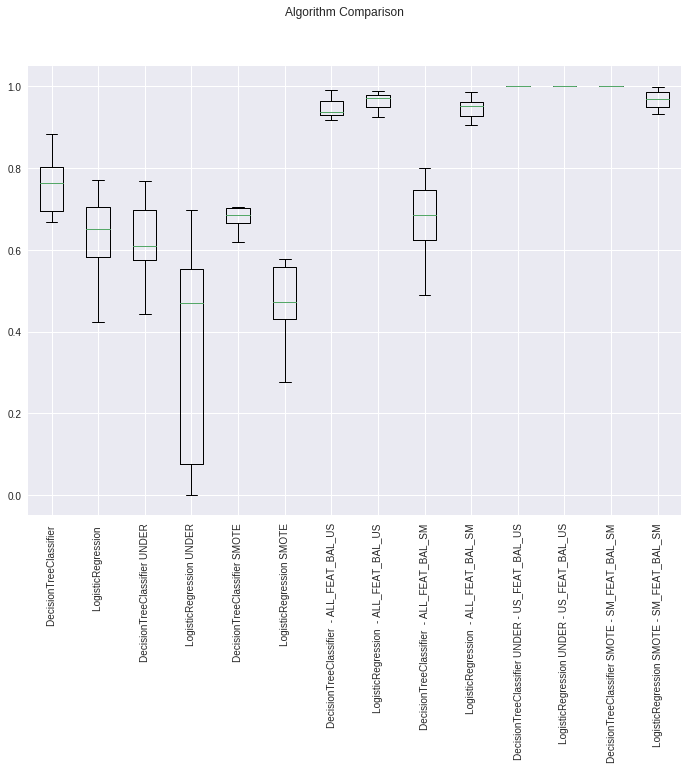

In [11]:
#balanceamento dos dados undersample
test_all_balance(models_sem, RandomUnderSampler(random_state=42), "ALL_FEAT_BAL_US", Xtrain, ytrain, Xtest, ytest, results, names)

#balanceamento de dados smote
test_all_balance(models_sem, SMOTE(random_state=42), "ALL_FEAT_BAL_SM", Xtrain, ytrain, Xtest, ytest, results, names)


#balanceamento dos dados undersample
test_all_balance(models_under, RandomUnderSampler(random_state=42), "US_FEAT_BAL_US", Xtrain, ytrain, Xtest, ytest, results, names)

#balanceamento de dados smote
test_all_balance(models_smote, SMOTE(random_state=42), "SM_FEAT_BAL_SM", Xtrain, ytrain, Xtest, ytest, results, names)


##Utilizando técnicas robustas ao desbalanceamento

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


{'n_estimators': 200}
0.8708001339188958
              precision    recall  f1-score   support

           0       0.30      0.86      0.44        87
           1       0.99      0.90      0.95      1843

   micro avg       0.90      0.90      0.90      1930
   macro avg       0.64      0.88      0.69      1930
weighted avg       0.96      0.90      0.92      1930

Matthews correlation coefficient
0.47058003185760583
G-mean
0.88250150906562


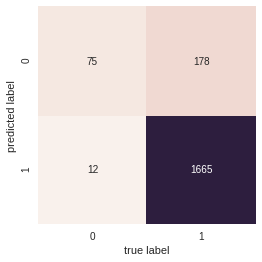

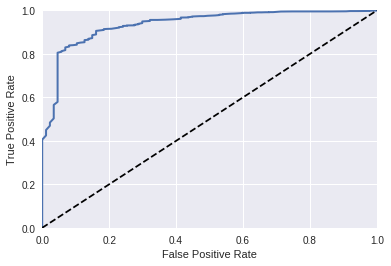

AUC: 0.936398
Score do conjunto de testes: 0.965514 (0.016166) 



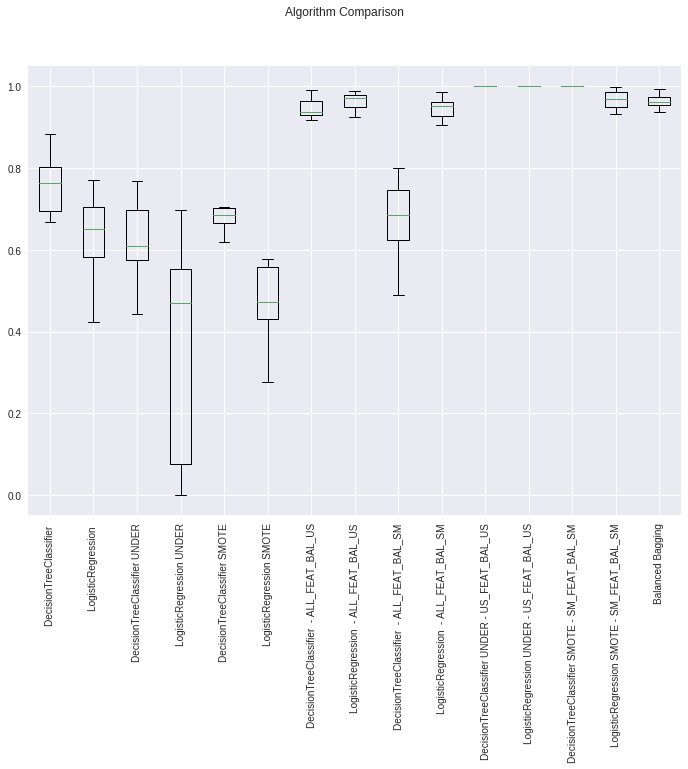

In [12]:
#BalancedBaggingClassifier

#classificador base DT
tree = DecisionTreeClassifier(max_features='auto')

#otimiza parâmetros
parameters = {'n_estimators': (10, 30, 100, 200, 300)}

grid = GridSearchCV(BalancedBaggingClassifier(base_estimator=tree),
                    param_grid=parameters,
                    cv=10, 
                    verbose=1,
                    n_jobs = -1,
                    scoring=make_scorer(geometric_mean_score))

#treina
grid.fit(Xtrain, ytrain)

#exibe melhor modelo
print(grid.best_params_)
print(grid.best_score_)
ensemble = grid.best_estimator_

#predicao
ypred_ensemble = ensemble.predict(Xtest)

#avaliacao
evaluating(ensemble, ytest, ypred_ensemble, Xtest)

cv_results = model_selection.cross_val_score(ensemble, Xtest, ypred_ensemble, 
                                             cv=model_selection.KFold(
                                                 n_splits=10, random_state=42),
                                                 scoring=make_scorer(geometric_mean_score))
                                             #scoring='recall_macro')
                                             #scoring='accuracy')

results.append(cv_results)
names.append('Balanced Bagging')

msg = "Score do conjunto de testes: %f (%f) \n" % (cv_results.mean(), cv_results.std())
print(msg)

# boxplot algorithm comparison
plot_alg_comp(results, names)

## Teste de p-value, a fim de confirmar se os desempenhos são diferentes

In [14]:
#test p-value 
from scipy.stats import ttest_ind

print(results)

alpha = 0.05

i = 0
for r1 in results:
    j = 0
    for r2 in results:
      tmp = names[i]+" x "+names[j]
      print(tmp)
      print('-'*len(tmp))
      
      
      stat, p = ttest_ind(r1, r2)
      print('Statistics=%.3f, p=%.3f' % (stat, p))
      # interpret
      if p > alpha:
        print('Same distributions (fail to reject H0)')
      else:
        print('Different distributions (reject H0)')
      
      j = j+1 
      
    i = i+1
    

[array([0.69958415, 0.3110005 , 0.88245306, 0.78668998, 0.8010688 ,
       0.66674991, 0.82741488, 0.69329862, 0.80329091, 0.73925475]), array([0.70710678, 0.546224  , 0.77046546, 0.4240521 , 0.57114202,
       0.73651717, 0.62017367, 0.64012545, 0.69950326, 0.66120955]), array([0.49734746, 0.44229901, 0.76839152, 0.73651717, 0.69758943,
       0.60136375, 0.61844857, 0.57735027, 0.69758943, 0.57420392]), array([0.49867549, 0.44229901, 0.        , 0.30151134, 0.69758943,
       0.        , 0.        , 0.5       , 0.56957939, 0.57420392]), array([0.70523365, 0.44599003, 0.76839152, 0.67234511, 0.69758943,
       0.67419986, 0.61844857, 0.76164985, 0.69758943, 0.6648526 ]), array([0.49867549, 0.44599003, 0.44363105, 0.42522839, 0.57114202,
       0.52223297, 0.2773501 , 0.57575317, 0.40496033, 0.57735027]), array([0.94228569, 0.9370582 , 0.9177921 , 0.92824589, 0.93039607,
       0.9701425 , 0.92566881, 0.97314946, 0.93601455, 0.9900824 ]), array([0.93374336, 0.96804283, 0.94764793, 0.98

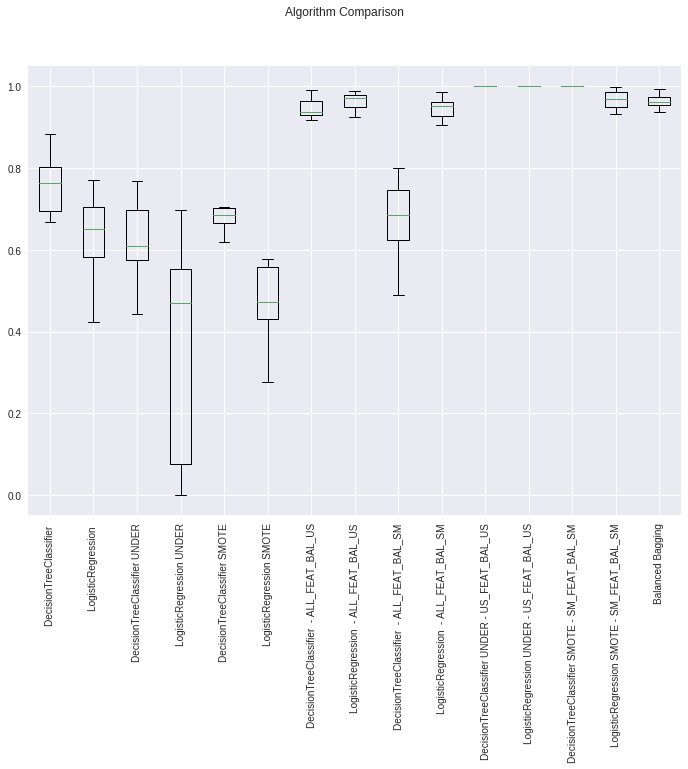

In [15]:
# boxplot algorithm comparison
plot_alg_comp(results, names)

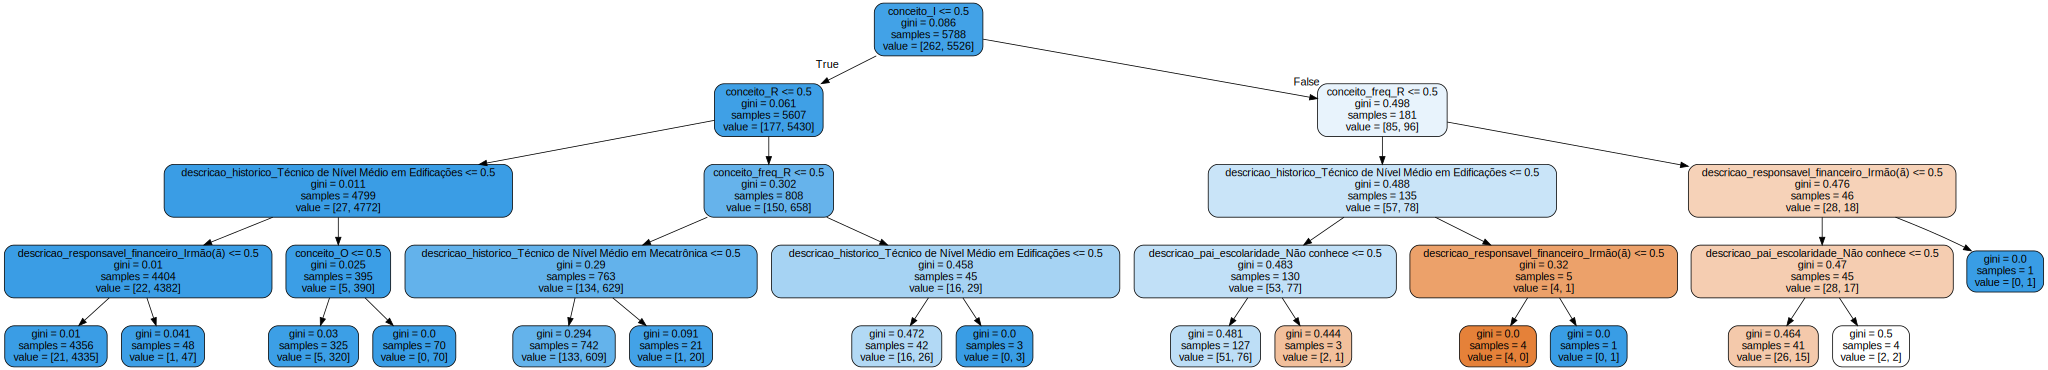

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(models_under[0].best_model, out_file=None
   , feature_names=models_under[0].best_attr
   , filled = True
   , rounded=True))
               
display(SVG(graph.pipe(format='svg')))



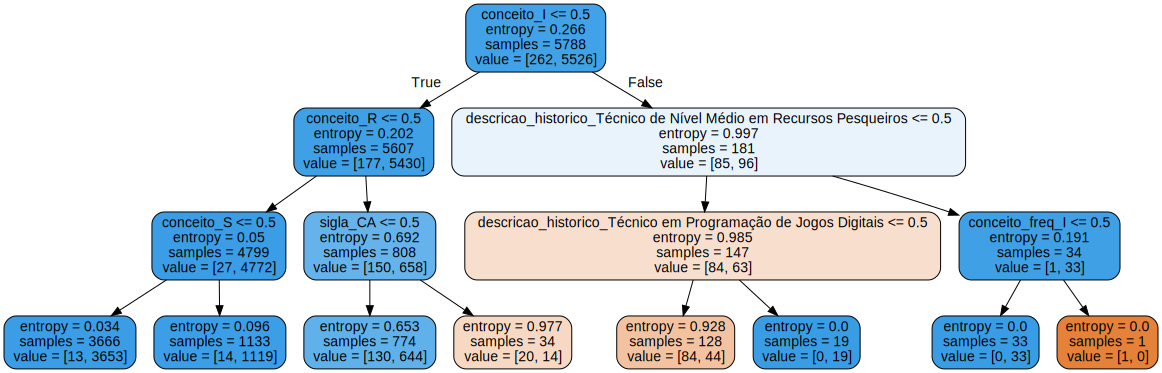

In [32]:
graph = Source(tree.export_graphviz(models_smote[0].best_model, out_file=None
   , feature_names=models_smote[0].best_attr
   , filled = True
   , rounded=True))
               
display(SVG(graph.pipe(format='svg')))



## Ranking feature BRF

Feature ranking:


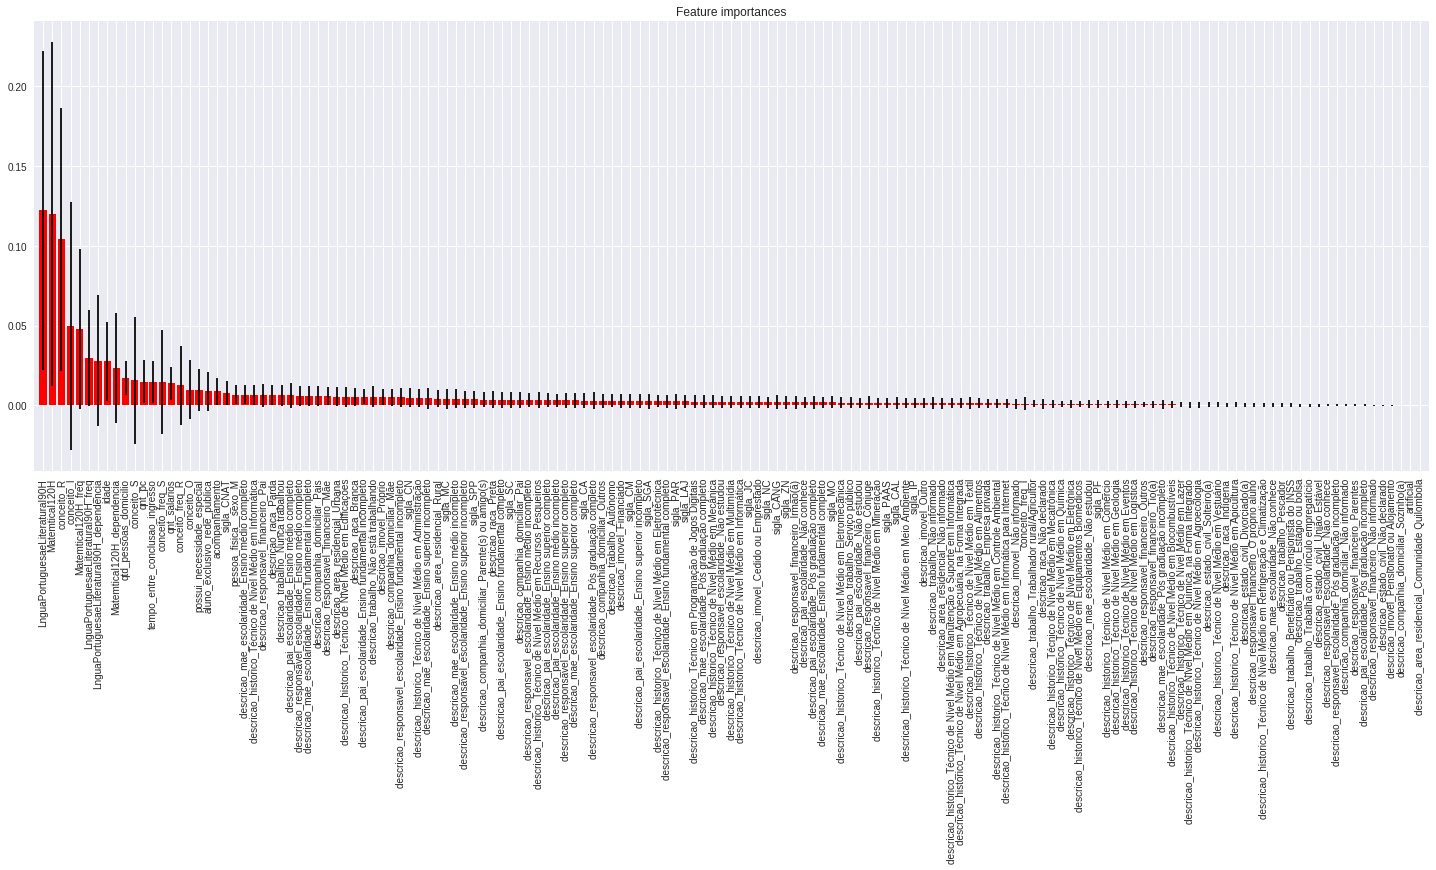

In [0]:

#std
std = np.std([est.steps[1][1].feature_importances_ for est in ensemble.estimators_], axis=0)

#mean
importances = np.mean([est.steps[1][1].feature_importances_ for est in ensemble.estimators_], axis=0)

#indices
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

# Plot the feature importances of the forest
fig = plt.figure()
fig.set_size_inches(25.0, 8.27)
plt.title("Feature importances")
plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
#plt.xticks(range(Xtest.shape[1]), indices)
plt.xticks(range(Xtest.shape[1]), Xtest.columns[indices])
#ax.set_xticklabels( names )
plt.xticks(rotation=90)
plt.xlim([-1, Xtest.shape[1]])
plt.show()


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


1. feature [LnguaPortuguesaeLiteraturaI90H] (0.122395) - Cumulative: 0.122395
2. feature [MatemticaI120H] (0.119922) - Cumulative: 0.242317
3. feature [conceito_R] (0.104195) - Cumulative: 0.346512
4. feature [conceito_I] (0.049486) - Cumulative: 0.395998
5. feature [MatemticaI120H_freq] (0.048006) - Cumulative: 0.444004
6. feature [LnguaPortuguesaeLiteraturaI90H_freq] (0.029798) - Cumulative: 0.473803
7. feature [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.028025) - Cumulative: 0.501828
8. feature [idade] (0.027704) - Cumulative: 0.529532
9. feature [MatemticaI120H_dependencia] (0.023495) - Cumulative: 0.553027
10. feature [qtd_pessoas_domicilio] (0.017140) - Cumulative: 0.570167
11. feature [conceito_S] (0.015681) - Cumulative: 0.585848
12. feature [qnt_pc] (0.014834) - Cumulative: 0.600682
13. feature [tempo_entre_conclusao_ingresso] (0.014777) - Cumulative: 0.615459
14. feature [conceito_freq_S] (0.014703) - Cumulative: 0.630163
15. feature [qnt_salarios] (0.013797) - Cumulative

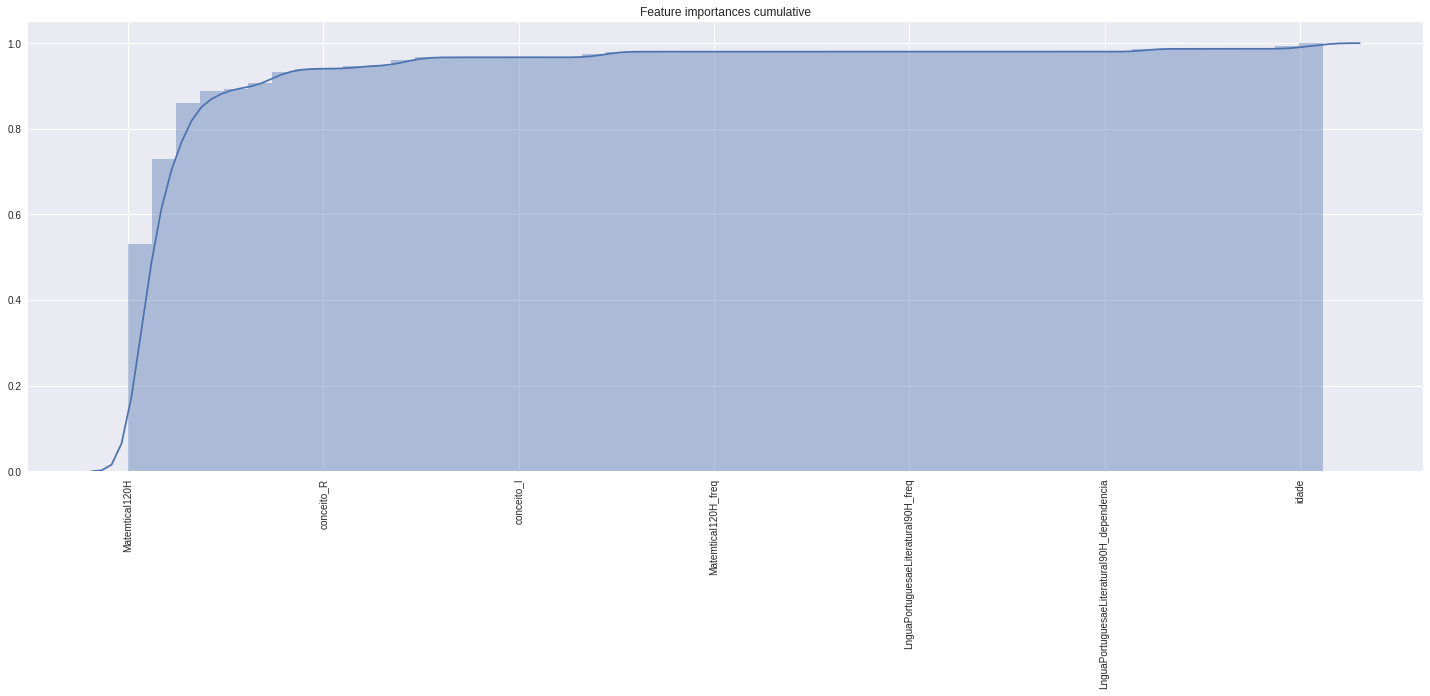

In [0]:

# Plot the feature importances of the forest
#fig, ax = plt.figure()
#figsize=(5, 5)
fig, ax = plt.subplots()
fig.set_size_inches(25.0, 8.27)
plt.title("Feature importances cumulative")

#plt.xticks(range(Xtest.shape[1]), Xtest.columns[indices])
plt.xticks(rotation=90)

g = sns.distplot(importances[indices], hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))

g.set(xticklabels=Xtest.columns[indices])

cum = 0
for f in range(Xtest.shape[1]):
  cum = cum + importances[indices[f]]
  print("%d. feature [%s] (%f) - Cumulative: %f" % (f + 1, Xtest.columns[indices[f]], importances[indices[f]], cum))